In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
def fetch_historical_weather(latitude, longitude, start_date, end_date, variables):
    base_url = "https://archive-api.open-meteo.com/v1/archive"
    
    params = {
        'latitude': latitude,
        'longitude': longitude,
        'start_date': start_date,
        'end_date': end_date,
        'hourly': ','.join(variables),
        'timezone': 'America/New_York',
        'models': 'best_match'
    }
    
    response = requests.get(base_url, params=params)
    if response.status_code == 200:
        return response.json()
    else:
        print({response.status_code})
        return None

**The above function fetches the weather data from the Open-Meteo API  for a specific location and time range. Inputs (parameters) are taken, there is a request to the API, and JSON data is returned upon success.**

In [4]:
def process_weather_data(api_response):
    # Create initial DataFrame with timestamp
    df = pd.DataFrame({
        'timestamp': api_response['hourly']['time']
    })
    
    # Add each weather variable as a separate column
    weather_vars = [var for var in api_response['hourly'] if var != 'time']
    for var in weather_vars:
        df[var] = api_response['hourly'][var]
    
    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])
    
    # Extract date features
    df['date'] = df['timestamp'].dt.date
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year

    # Convert temperature columns to Fahrenheit
    temp_cols = [col for col in df.columns if 'temperature' in col]
    for col in temp_cols:
        f_col = col.replace('temperature', 'temp_fahrenheit')
        df[f_col] = (df[col] * 9/5) + 32
    
    return df

**The above function transforms raw API data into a structured DataFrame for analysis. JSON 'hourly' data is converted to a DataFrame, and timestamp along with all weather variables are kept. Time strings are converted to datetime objects, and we extract the date, month, and year for analysis. Celsius is also converted to Fahrenheit.**

In [6]:
# NYC coordinates
nyc_lat = 40.7128
nyc_long = -74.0060

# Define time period from 2020-2025 (last 5 years)
end_date = datetime.now().strftime('%Y-%m-%d')
start_date = (datetime.now() - pd.DateOffset(years=5)).strftime('%Y-%m-%d')

# Variables wanted
variables = [
    'temperature_2m',
    'relativehumidity_2m',
    'precipitation',
    'weathercode',
    'windspeed_10m'
]

# Fetch data
nyc_weather = fetch_historical_weather(nyc_lat, nyc_long, start_date, end_date, variables)

# Process data
nyc_df = process_weather_data(nyc_weather)

**The above code block is a demonstration on how to use the previous two functions. We setup a location in NYC using latitude and longitutde coordinates, create a time window from 5 years ago to today, define the variables we want to collect, and call the fethcing and processing functions.**

In [8]:
# Aggregate hourly data to daily
daily_weather = nyc_df.groupby('date').agg({
    'temperature_2m': ['mean', 'min', 'max'],
    'temp_fahrenheit_2m': ['mean', 'min', 'max'],
    'precipitation': 'sum',
    'windspeed_10m': 'mean',
}).reset_index()

# Flatten multi-index columns
daily_weather.columns = ['_'.join(col).strip() if col[1] else col[0] 
                        for col in daily_weather.columns.values]

**The above code block groups hourly data by 'date' and calculates means, minimums, maximums, and sums for different weather variables. The columns were flattened, as well.**

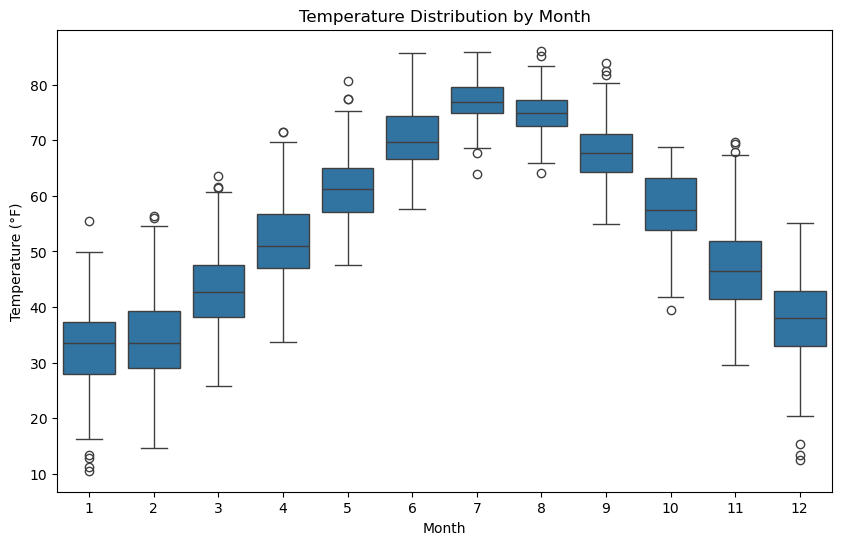

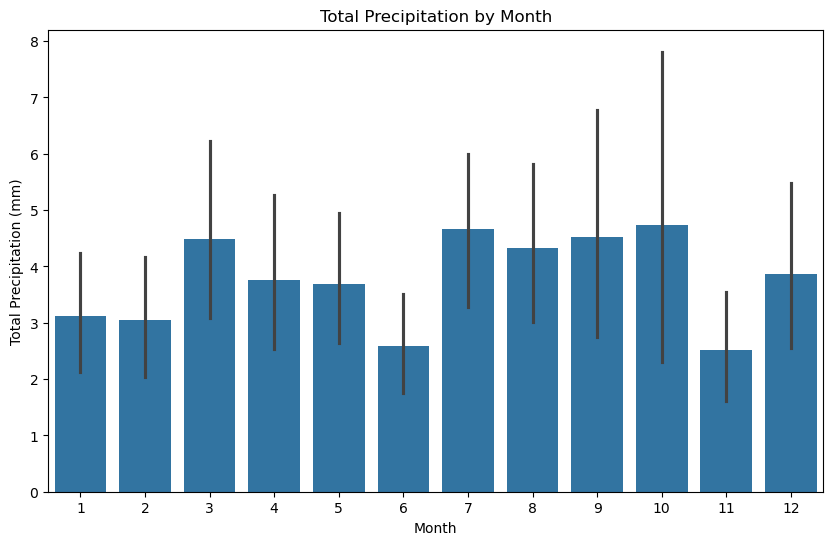

In [10]:
# Add month column to daily data
daily_weather['date'] = pd.to_datetime(daily_weather['date'])
daily_weather['month'] = daily_weather['date'].dt.month

# Plot average temperature by month
plt.figure(figsize=(10, 6))
sns.boxplot(data=daily_weather, x='month', y='temp_fahrenheit_2m_mean')
plt.title('Temperature Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Temperature (°F)')
plt.show()

# Plot precipitation by month
plt.figure(figsize=(10, 6))
sns.barplot(data=daily_weather, x='month', y='precipitation_sum')
plt.title('Total Precipitation by Month')
plt.xlabel('Month')
plt.ylabel('Total Precipitation (mm)')
plt.show()

**The above code block first converts the date column to datetime (if it isn't already), and extracts the month number into a new month column. Two visualizations are then plotted, displaying the temperature distribution by month and the total precipitation by month in NYC. We can identify the best months/times to travel based on comfortable temperature ranges and the amount of rain.**

In [12]:
def calculate_travel_score(row):
    # Ideal temperature range (59-77°F)
    temp_score = 0
    if 59 <= row['temp_fahrenheit_2m_mean'] <= 77:
        temp_score = 100 - 2.22 * abs(row['temp_fahrenheit_2m_mean'] - 68)
        
    # Deduct points for precipitation
    precip_score = max(0, 100 - row['precipitation_sum'] * 10)
    
    # Deduct points for high winds
    wind_score = max(0, 100 - row['windspeed_10m_mean'] * 5)
    
    # Score formula with weights
    total_score = 0.5 * temp_score + 0.3 * precip_score + 0.2 * wind_score
    
    return total_score

**The above code block calculates a score from 0 to 100 representing how good the weather is for travel, with temperature having a 50% weight, precipitation having a 30% weight, and wind having a 20% weight. The temperature score is designed around 68°F, the sweet spot for comfort. It deducts 2.22 points per degree you stray from this ideal, ensuring scores stay high (80+) in the 59–77°F range but drop sharply outside it. For precipitation, the score loses 10 points per 1mm of rain, so a day with 5mm of rain cuts 50 points from the max. This harsh penalty reflects how rain disrupts travel plans more than minor temperature changes. High winds deduct 5 points per 1 m/s, as strong winds make walking uncomfortable but aren’t as punishing as rain.**

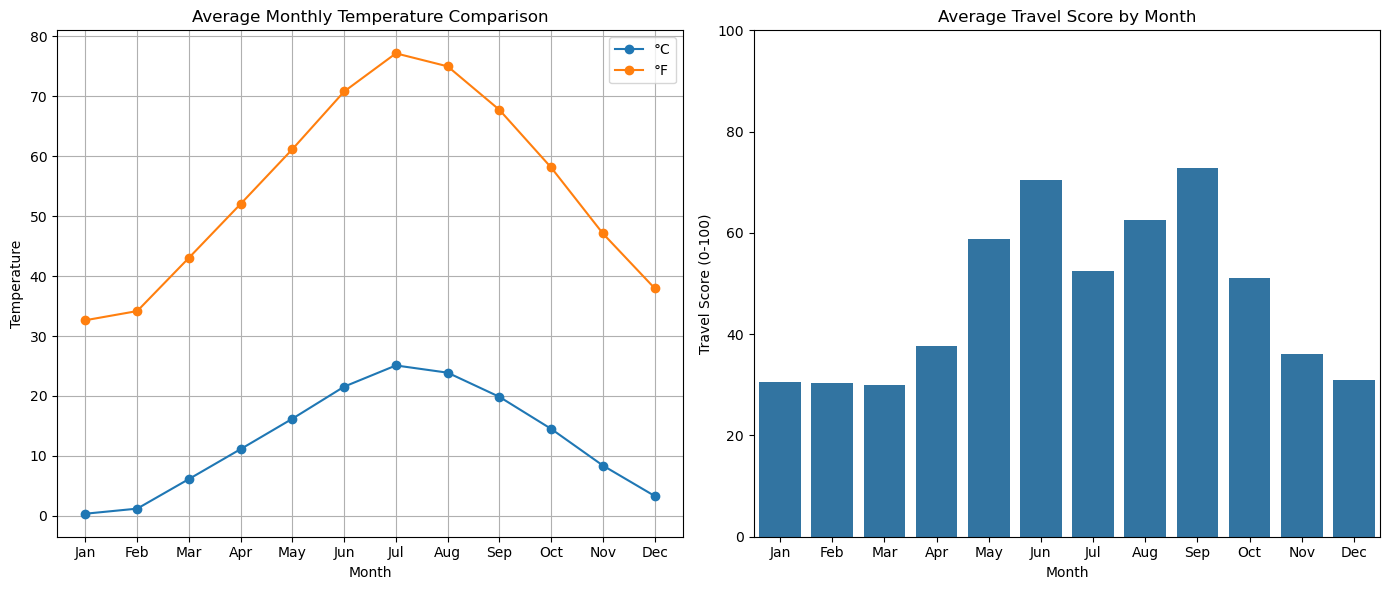


Monthly Averages:


,month_name,avg_temp_c,avg_temp_f,avg_precipitation_mm,avg_windspeed_kph,avg_travel_score
0,Jan,0.354543,32.638177,3.114194,13.895484,30.490242
1,Feb,1.201507,34.162713,3.048936,13.751862,30.266253
2,Mar,6.141828,43.055290,4.482581,14.895645,29.996656
3,Apr,11.137917,52.048250,3.757333,14.293056,37.649088
4,May,16.209059,61.176306,3.684516,12.308898,58.727267
5,Jun,21.553559,70.796407,2.594040,12.263918,70.494198
6,Jul,25.089543,77.161177,4.658710,11.043280,52.472664
7,Aug,23.883495,74.990290,4.334194,11.499140,62.532293
8,Sep,19.852806,67.735050,4.526000,12.312583,72.847513
9,Oct,14.509301,58.116742,4.728387,12.626989,51.150881


In [14]:
# Ensure we have the month column in daily_weather
daily_weather['month'] = pd.to_datetime(daily_weather['date']).dt.month

# Apply the scoring function to create the travel_score column
daily_weather['travel_score'] = daily_weather.apply(calculate_travel_score, axis=1)

# Group by month and calculate average metrics including travel score
monthly_avg = daily_weather.groupby('month').agg({
    'temperature_2m_mean': 'mean',        # Celsius mean
    'temp_fahrenheit_2m_mean': 'mean',    # Fahrenheit mean
    'precipitation_sum': 'mean',          # Average precipitation
    'windspeed_10m_mean': 'mean',        # Average wind speed
    'travel_score': 'mean'               # Average travel score
}).reset_index()

# Rename columns
monthly_avg = monthly_avg.rename(columns={
    'temperature_2m_mean': 'avg_temp_c',
    'temp_fahrenheit_2m_mean': 'avg_temp_f',
    'precipitation_sum': 'avg_precipitation_mm',
    'windspeed_10m_mean': 'avg_windspeed_kph',
    'travel_score': 'avg_travel_score'
})

# Add month names for better visualization
monthly_avg['month_name'] = monthly_avg['month'].apply(lambda x: datetime.strptime(str(x), '%m').strftime('%b'))

# Create the visualization
plt.figure(figsize=(14, 6))

# Plot Average Monthly Temperature Comparison
plt.subplot(1, 2, 1)
plt.plot(monthly_avg['month_name'], monthly_avg['avg_temp_c'], 'o-', label='°C')
plt.plot(monthly_avg['month_name'], monthly_avg['avg_temp_f'], 'o-', label='°F')
plt.title('Average Monthly Temperature Comparison')
plt.xlabel('Month')
plt.ylabel('Temperature')
plt.legend()
plt.grid(True)

# Plot Average Travel Score by Month
plt.subplot(1, 2, 2)
sns.barplot(data=monthly_avg, x='month_name', y='avg_travel_score')
plt.title('Average Travel Score by Month')
plt.xlabel('Month')
plt.ylabel('Travel Score (0-100)')
plt.ylim(0, 100)

plt.tight_layout()
plt.show()

# Display the monthly averages table
print("\nMonthly Averages:")
display(monthly_avg[['month_name', 'avg_temp_c', 'avg_temp_f', 
                    'avg_precipitation_mm', 'avg_windspeed_kph', 
                    'avg_travel_score']])

**The above code block analyzes weather data to determine the best months for travel based on temperature, precipitation, and wind conditions. Here's how it works in simple terms:**

**First, it adds a month column to the daily weather data to organize data by month. Then it calculates the travel score for each day using the beforementioned formula. After calculating daily scores, the code groups the data by month to find average values for temperature (in both Celsius and Fahrenheit), precipitation, wind speed, and the overall travel score. Visualizations are then created: a line chart comparing monthly temperatures in both Celsius and Fahrenheit, and a bar chart showing the average travel score for each month. Finally, it displays a clean table summarizing these monthly averages, making it easy to see which months typically offer the best travel weather based on the combined score and individual weather factors. The higher the travel score, the better the weather conditions are for traveling during that month.**

In [16]:
# Coordinates for different cities
cities = {
    "New York": (40.7128, -74.0060),
    "Los Angeles": (34.0522, -118.2437),
    "Chicago": (41.8781, -87.6298),
    "Miami": (25.7617, -80.1918),
    "Seattle": (47.6062, -122.3321)
}

def fetch_all_cities_data(cities, start_date, end_date, variables):
    all_cities = []
    
    for city_name, (lat, lon) in cities.items():
        data = fetch_historical_weather(lat, lon, start_date, end_date, variables)
        if data:
            df = process_weather_data(data)
            df['city'] = city_name  # Tag each row with its city
            all_cities.append(df)
    
    return pd.concat(all_cities, ignore_index=True)

# Usage:
variables = ['temperature_2m', 'precipitation', 'windspeed_10m', 'relativehumidity_2m']
all_cities_df = fetch_all_cities_data(cities, start_date, end_date, variables)

**The above code block collects and organizes historical weather data for multiple U.S. cities to support travel planning analysis. A dictionary of five major cities is defined. The main function retrieves weather information for each city by looping through the city dictionary, calling the Open-Meteo API for each location using the specified date range and weather variables (temperature, precipitation, wind speed, and humidity), and processing the raw API response into a clean DataFrame format. As it gathers data for each city, the function adds a 'city' column to each city's weather data, labeling every record with its respective city name. Finally, it combines all the individual city DataFrames into one dataset. The resulting 'all_cities_df' contains processed historical weather observations for all of the specified cities.**

In [18]:
def calculate_daily_metrics(df):
    daily = df.groupby(['city', 'date']).agg({
        'temp_fahrenheit_2m': ['mean', 'max', 'min'],
        'precipitation': 'sum',
        'windspeed_10m': 'mean',
        'relativehumidity_2m': 'mean'
    }).reset_index()
    
    # Flatten multi-index columns
    daily.columns = ['_'.join(col).strip() if col[1] else col[0] 
                    for col in daily.columns.values]
    return daily

daily_metrics = calculate_daily_metrics(all_cities_df)

In [19]:
def apply_city_scores(df):
    df['travel_score'] = df.apply(lambda row: (
        0.5 * (100 - 2.22 * abs(row['temp_fahrenheit_2m_mean'] - 68)) +  # Temperature (ideal ~68°F)
        0.3 * (100 - row['precipitation_sum'] * 10) +                 # Precipitation
        0.2 * (100 - row['windspeed_10m_mean'] * 3)), axis=1)
    return df

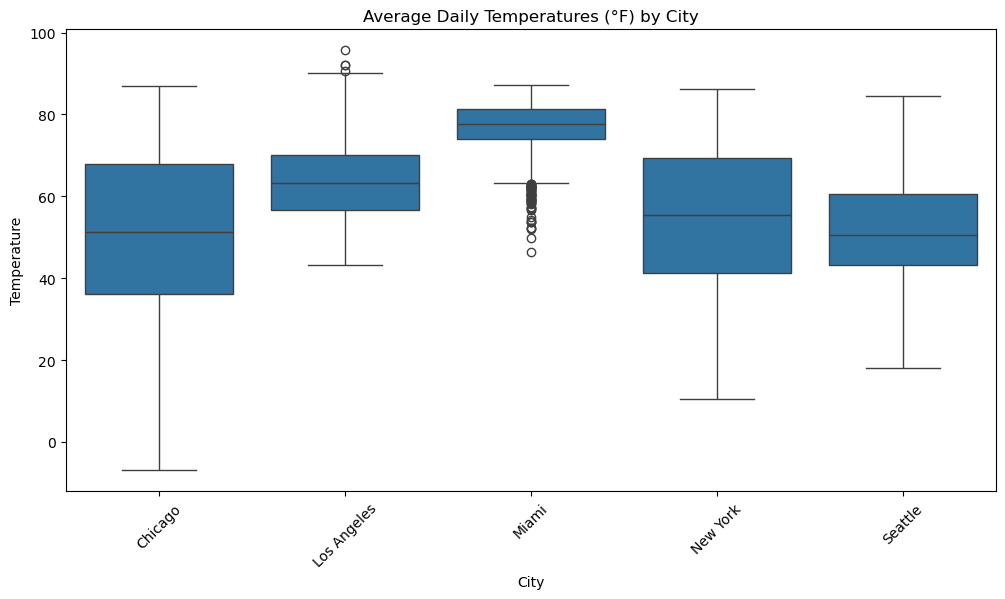

In [20]:
# Ensure we have the processed data
daily_metrics = calculate_daily_metrics(all_cities_df)

# Calculate scores
scored_cities = apply_city_scores(daily_metrics)

# Visualize
plt.figure(figsize=(12, 6))
sns.boxplot(data=scored_cities, x='city', y='temp_fahrenheit_2m_mean')
plt.title("Average Daily Temperatures (°F) by City")
plt.xlabel('City')
plt.ylabel('Temperature')
plt.xticks(rotation=45)
plt.show()

**The above code block visualizes city weather data. First, it processes the raw hourly data into daily summaries using the 'calculate_daily_metrics' function. Next, it applies the travel scoring system through 'apply_city_scores', which evaluates each day's travel score. Finally, it generates a boxplot visualization comparing temperature distributions across cities.**

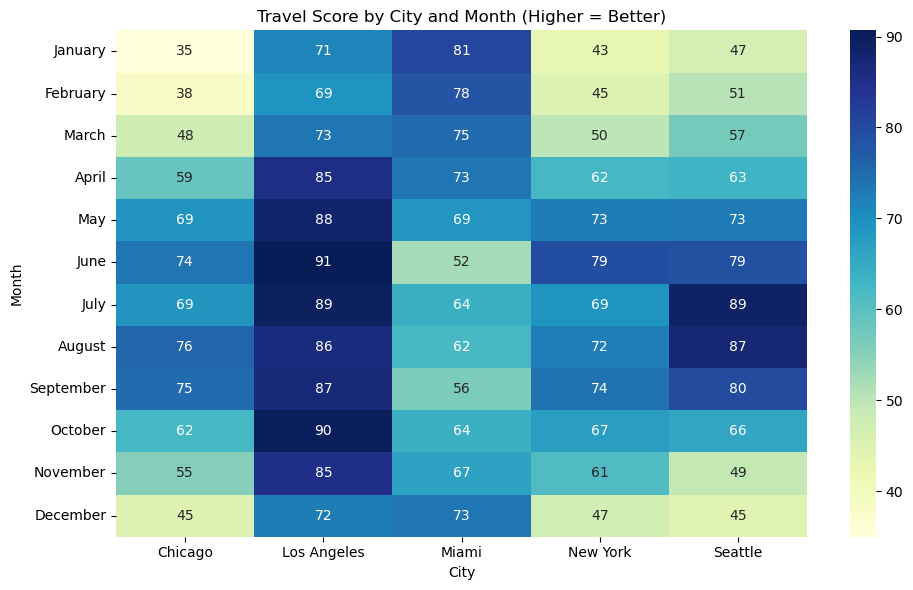

In [22]:
# Ensure we have the month column
scored_cities['date'] = pd.to_datetime(scored_cities['date'])  # Ensure date is datetime
scored_cities['month'] = scored_cities['date'].dt.month  # Extract month
scored_cities['month_name'] = scored_cities['date'].dt.month_name()  # Add month names

# Calculate monthly averages
monthly_scores = scored_cities.groupby(['city', 'month', 'month_name']).agg({
    'travel_score': 'mean',
    'temp_fahrenheit_2m_mean': 'mean',
    'precipitation_sum': 'mean'
}).reset_index()

# Create heatmap data
heatmap_data = monthly_scores.pivot(
    index='month_name', 
    columns='city', 
    values='travel_score'
)

# Sort months chronologically instead of alphabetically
month_order = ['January', 'February', 'March', 'April', 'May', 'June', 
               'July', 'August', 'September', 'October', 'November', 'December']
heatmap_data = heatmap_data.reindex(month_order)

# Plot
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="YlGnBu")
plt.title("Travel Score by City and Month (Higher = Better)")
plt.xlabel("City")
plt.ylabel("Month")
plt.tight_layout()
plt.show()

**The above code analyzes and visualizes monthly travel comfort scores across different cities. First, it processes the dated weather data by extracting month numbers (1-12) and names (like "January") from each record. Then it calculates average monthly scores for each city, considering three overall travel score, average temperature, and total precipitation. A color-coded heatmap is generated where darker shades indicate better travel scores. This visualization makes it easy to compare seasonal patterns across locations - for example, showing how southern cities might score higher in winter while northern cities perform better in summer - helping travelers identify the optimal time to visit each destination based on weather comfort.**

In [24]:
# Add seasonal markers
scored_cities['season'] = scored_cities['month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})

# Add weather severity flags
scored_cities['heat_wave'] = (scored_cities['temp_fahrenheit_2m_mean'] > 85).astype(int)
scored_cities['rainy_day'] = (scored_cities['precipitation_sum'] > 5).astype(int)

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Prepare data for prediction
model_data = scored_cities.groupby(['city', 'month']).agg({
    'travel_score': 'mean',
    'temp_fahrenheit_2m_mean': 'mean',
    'precipitation_sum': 'mean',
    'heat_wave': 'sum',
    'rainy_day': 'sum'
}).reset_index()

# One-hot encode cities
model_data = pd.get_dummies(model_data, columns=['city'])

X = model_data.drop('travel_score', axis=1)
y = model_data['travel_score']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Train model
model = RandomForestRegressor()
model.fit(X_train, y_train)

RandomForestRegressor()

**The two above code blocks enhances the weather analysis by adding seasonal categorization and weather flags before training a predictive model. First, it classifies each month into seasons and identifies harsh conditions by flagging days with temperatures above 85°F as heat waves and days with more than 5mm of rain as rainy days. The data is then aggregated by city and month to calculate average travel scores along with weather metrics and counts of 'bad' weather days.**

**To prepare for ML, the code converts city names into numerical format using one-hot encoding (creating separate columns for each city) and splits the data into training (80%) and testing (20%) sets. Finally, it trains a Random Forest regression model to predict travel scores based on weather patterns and seasonal factors. This model can learn complex relationships between weather conditions and travel comfort, potentially enabling predictions for future dates or different locations. The inclusion of extreme weather flags helps capture important patterns that might affect travel plans beyond average conditions.**

In [27]:
# Prepare prediction data with all city columns
def prepare_prediction_data(model_data, cities):
    future_data = pd.DataFrame({'month': range(1,13)})
    
    # Add median values for weather features
    for col in ['temp_fahrenheit_2m_mean', 'precipitation_sum', 'heat_wave', 'rainy_day']:
        future_data[col] = model_data[col].median()
    
    # Create one-hot columns for ALL cities
    for city in cities:
        future_data[f'city_{city}'] = 0
    
    return future_data

# Generate predictions for each city
predictions = []
for city in cities:
    future_data = prepare_prediction_data(model_data, cities)
    future_data[f'city_{city}'] = 1  # Activate only current city
    
    # Ensure column order matches training data
    future_data = future_data[X_train.columns]
    
    preds = model.predict(future_data)
    predictions.append(pd.DataFrame({
        'city': city,
        'month': future_data['month'],
        'predicted_score': preds
    }))

# Combine results
predictions_df = pd.concat(predictions)
predictions_df

,city,month,predicted_score
0,New York,1,72.304371
1,New York,2,72.304371
2,New York,3,72.573550
3,New York,4,72.551935
4,New York,5,72.593512
5,New York,6,72.531469
6,New York,7,72.593508
7,New York,8,72.484595
8,New York,9,72.404405
9,New York,10,72.261139


In [28]:
predictions_df.to_csv("final_predictions.csv", index=False)

**The above code block generates monthly travel score predictions for each city using the trained Random Forest model. It works in three stages: First, it creates a template dataset ('prepare_prediction_data') containing all months with median weather values as baseline conditions, plus placeholder columns for all cities. Then, for each specific city, it activates only that city's column (setting it to 1 while others remain 0) while keeping other weather features at their median values - this essentially asks the model "what would the score be for each month if this city had average weather conditions?" The code ensures the data structure exactly matches what the model was trained on by aligning the column order. Finally, it combines all cities' predictions into one clean DataFrame ('predictions_df') showing expected monthly travel scores for each location.**

In [30]:
city_rankings = predictions_df.groupby('city')['predicted_score'].mean().sort_values(ascending=False)
city_rankings.to_csv("city_rankings.csv")
city_rankings

city
New York       72.432791
Miami          72.249980
Seattle        72.234060
Los Angeles    72.187193
Chicago        71.681424
Name: predicted_score, dtype: float64

In [31]:
seasonal_patterns = scored_cities.groupby(['city', 'season'])['travel_score'].mean().unstack()
seasonal_patterns.to_csv("seasonal_patterns.csv")
seasonal_patterns

season,Fall,Spring,Summer,Winter
city,,,,
Chicago,64.187682,58.518071,72.716282,39.472681
Los Angeles,87.538125,82.391135,88.797961,71.134855
Miami,62.355907,72.379571,59.591322,77.362867
New York,67.557199,61.594361,73.551431,45.158389
Seattle,65.015942,64.247847,85.074092,47.131148


In [32]:
# 1. Calculate seasonal averages
seasonal_avg = scored_cities.groupby(['city', 'season']).agg({
    'travel_score': 'mean',
    'temp_fahrenheit_2m_mean': 'mean',
    'precipitation_sum': 'mean'
}).reset_index()

seasonal_avg.to_csv("seasonal_avg_scores.csv", index=False)